In [1]:
1

1

In [2]:
using DiffEqSensitivity, OrdinaryDiffEq, Zygote

In [3]:
using Flux
using Flux: Params, gradient, mse, glorot_normal, throttle
using DiffEqFlux
using Sundials

In [4]:
function case1_ode(dydt, y, k, t)
  dydt[1] = -2 * k[1] * y[1]^2 - k[2] * y[1]
  dydt[2] = k[1] * y[1]^2 - k[4] * y[2] * y[4]
  dydt[3] = k[2] * y[1] - k[3] * y[3]
  dydt[4] = k[3] * y[3] - k[4] * y[2] * y[4]
  dydt[5] = k[4] * y[2] * y[4]
end

case1_ode (generic function with 1 method)

In [5]:
k = [0.1, 0.2, 0.13, 0.3]
u0 = [1.0;1.0;0.0;0.0;0.0]
tspan = [0.0,20.0]
nothing

In [57]:
alg = Rosenbrock23(autodiff=false)
# alg = CVODE_BDF()
# alg = Tsit5()

Rosenbrock23{0,false,DefaultLinSolve,DataType}(DefaultLinSolve(nothing, nothing), Val{:forward})

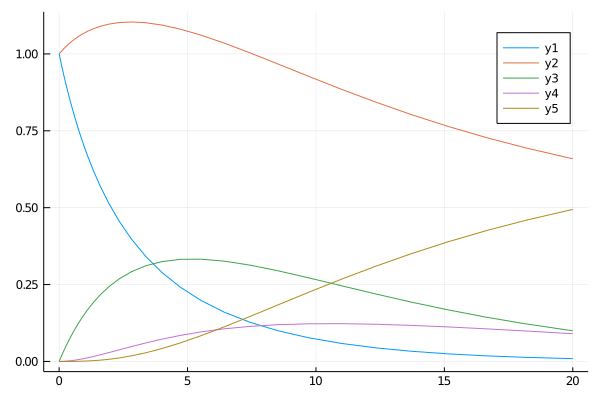

In [58]:
prob_trueode = ODEProblem(case1_ode,u0,tspan,k)
sol_trueode = concrete_solve(prob_trueode,alg)

using Plots
plot(sol_trueode)

In [59]:
t = sol_trueode.t
ode_data = Array(sol_trueode)
nothing

In [60]:
dudt2 = Chain(x -> log.(clamp.(x, 1e-30, 10)),
              Dense(5, 3, exp),
              Dense(3, 5))

dudt2.layers[2].W .= clamp.(dudt2.layers[2].W, 0, 4)

p,re = Flux.destructure(dudt2) # use this p as the initial condition!

dudt(u,p,t) = re(p)(u) # need to restrcture for backprop!

prob_crnn = ODEProblem(dudt,u0,tspan)

function predict_n_ode()
  Array(concrete_solve(prob_crnn,alg,u0,p,saveat=t))
end

function loss_n_ode()
    pred = predict_n_ode()
    loss = sum(abs2,ode_data .- pred)
    loss
end

loss_n_ode() # n_ode.p stores the initial parameters of the neural ODE

MethodError: MethodError: no method matching finite_difference_jacobian(::DiffEqBase.UDerivativeWrapper{ODEFunction{false,typeof(dudt),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Float64,Array{Float32,1}}, ::Array{Float64,1}, ::Type{Val{:forward}}, ::Type{Float64}, ::Array{Float32,1}; dir=true, colorvec=1:5, sparsity=nothing, jac_prototype=nothing)
Closest candidates are:
  finite_difference_jacobian(::Any, ::AbstractArray{#s76,N} where N where #s76<:Number, ::Type{T1}, ::Type{T2}) where {T1, T2} at /home/jiweiqi/.julia/packages/FiniteDiff/cB7yD/src/jacobians.jl:138 got unsupported keyword arguments "dir", "colorvec", "sparsity", "jac_prototype"
  finite_difference_jacobian(::Any, ::AbstractArray{#s75,N} where N where #s75<:Number, ::Type{T1}, ::Type{T2}, !Matched::Union{Nothing, AbstractArray{#s74,N} where N where #s74<:T2}; relstep, absstep, colorvec, sparsity, jac_prototype, dir) where {T1, T2} at /home/jiweiqi/.julia/packages/FiniteDiff/cB7yD/src/jacobians.jl:138
  finite_difference_jacobian(::Any, ::AbstractArray{#s77,N} where N where #s77<:Number, ::Type{T1}) where T1 at /home/jiweiqi/.julia/packages/FiniteDiff/cB7yD/src/jacobians.jl:138 got unsupported keyword arguments "dir", "colorvec", "sparsity", "jac_prototype"
  ...

10.690909358168744

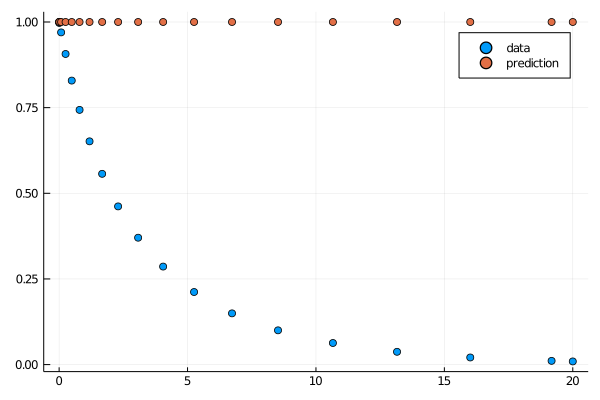

false

In [54]:
cb = function (;doplot=false) #callback function to observe training
  dudt2.layers[2].W .= clamp.(dudt2.layers[2].W, 0, 4)
    
  pred = predict_n_ode()
  display(sum(abs2,ode_data .- pred))
  
  # plot current prediction against data
  pl = scatter(t,ode_data[1,:],label="data")
  scatter!(pl,t,pred[1,:],label="prediction")
  display(plot(pl))
  return false
end

# Display the ODE with the initial parameter values.
cb()

7.1126804602448095

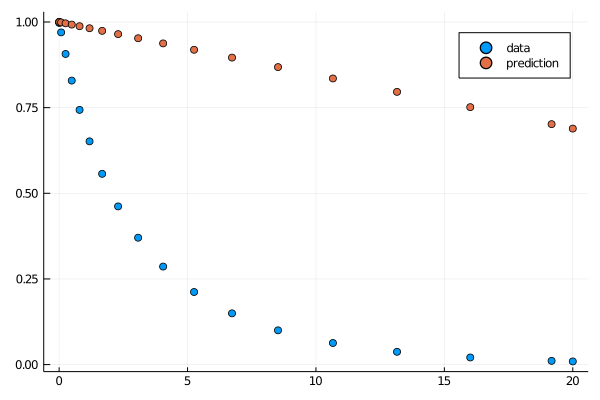

InterruptException: InterruptException:

In [56]:
data = Iterators.repeated((), 100)
Flux.train!(loss_n_ode, Flux.params(p), data, ADAM(0.01), cb = cb)